# LSMS Linear Regression 
Predict farm-level yields using vegetation index measures.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [2]:
df = pd.read_csv('Feb_Apr_2015_Training_Data.csv')

In [3]:
del(df['.geo'])

In [4]:
print(f"There are {df.shape[0]} observations prior to removing NAs")
df = df.dropna()
print(f"There are {df.shape[0]} observations after removing NAs")

There are 25496 observations prior to removing NAs
There are 23808 observations after removing NAs


In [5]:
crops_encoded = pd.get_dummies(pd.DataFrame(df['Crop Name']))

In [6]:
crop_cols = list(crops_encoded.columns)

In [7]:
df = df.join(crops_encoded)

In [8]:
base_x_cols = ['NDVI_mean', 'mean_EVI', 'TVI_mean']
all_x_cols = base_x_cols + crop_cols

In [9]:
y = df[['Quantity (kg)']]
x = df[base_x_cols]

In [10]:
x.describe()

,NDVI_mean,mean_EVI,TVI_mean
count,23808.000000,23808.000000,23808.000000
mean,0.394797,0.287356,7.722741
std,0.135379,0.122138,3.643130
min,0.156796,0.069933,1.508189
25%,0.293116,0.185634,5.069314
50%,0.378602,0.279933,6.912983
75%,0.461784,0.380146,9.084865
max,0.815148,0.661012,22.811400


In [11]:
y.describe()

,Quantity (kg)
count,23808.000000
mean,96.883760
std,154.216781
min,0.000000
25%,3.000000
50%,34.375999
75%,112.129997
max,1000.000000


In [12]:
mod = sm.OLS(y,x)

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:          Quantity (kg)   R-squared (uncentered):                   0.238
Model:                            OLS   Adj. R-squared (uncentered):              0.238
Method:                 Least Squares   F-statistic:                              2479.
Date:                Thu, 03 Oct 2019   Prob (F-statistic):                        0.00
Time:                        18:37:33   Log-Likelihood:                     -1.5446e+05
No. Observations:               23808   AIC:                                  3.089e+05
Df Residuals:                   23805   BIC:                                  3.089e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Total predicted yield in 2015 (for farms):

In [13]:
res.predict(x).sum()

2032043.3112016888

Total actual yield in 2015 (for farms):

In [14]:
y.sum()['Quantity (kg)']

2306608.5698114033

## Predictions

In [15]:
df = pd.read_csv('Feb_Apr_2018_Forecast_Data.csv')
x_2018 = df[['NDVI_mean', 'mean_EVI', 'TVI_mean']]

df = pd.read_csv('Feb_Apr_2017_Forecast_Data.csv')
x_2017 = df[['NDVI_mean', 'mean_EVI', 'TVI_mean']]

df = pd.read_csv('Feb_Apr_2016_Forecast_Data.csv')
x_2016 = df[['NDVI_mean', 'mean_EVI', 'TVI_mean']]

In [16]:
y_15 = res.predict(x).sum()

In [17]:
y_16 = res.predict(x_2016).sum()

In [18]:
y_17 = res.predict(x_2017).sum()

In [19]:
y_18 = res.predict(x_2018).sum()

In [20]:
output = {'Year': [2015, 2016, 2017, 2018], 'Predictions': [y_15, y_16, y_17, y_18]}

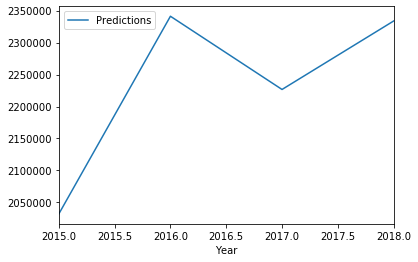

In [24]:
df.from_dict(output).plot('Year','Predictions')

In [22]:
actuals = {'Year': [2015, 2016, 2017, 2018], 'Actuals': [  270396048.03 , 266828807.04 ,  290385593.21 ,  306126383.06]}

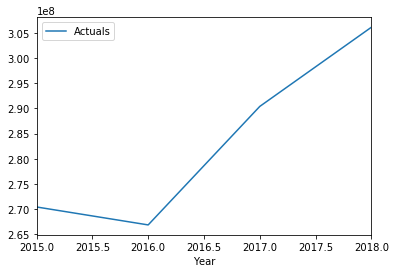

In [23]:
df.from_dict(actuals).plot('Year','Actuals')